In [2]:
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import random
%matplotlib inline
import pickle as pkl
from tqdm import tqdm_notebook
random.seed(134)

In [3]:
#change labels
def change_label(label):
    if label == 'neutral':
        return 0.0
    elif label == 'entailment':
        return 1.0
    elif label == 'contradiction':
        return 2.0
    
def split_file_token(file):
    file_ls = []
    y = []
    with open(file) as fd:
        rd = csv.reader(fd, delimiter="\t", quotechar=' ')
        for row in rd:
            if row[0] == 'sentence1':
                pass
            else:
                file_ls.append([row[0].split(),row[1].split()])
                y.append(change_label(row[2]))
    return file_ls,y

In [4]:
snli_train_path = "hw2_data/snli_train.tsv"      
snli_train_token,snli_train_y = split_file_token(snli_train_path)
snli_val_path = "hw2_data/snli_val.tsv"
snli_val_token,snli_val_y = split_file_token(snli_val_path)

In [5]:
def tokenizer_dt(tokenizer_pair):
    premise = []
    hypothesis = []
    for i in tokenizer_pair:
        premise.append(i[0])
        hypothesis.append(i[1])
    return premise,hypothesis

#build vocabulary dictionary
PAD_IDX = 0
UNK_IDX = 1
Emb_Mtx = []
snli_train_token2id = {}
snli_train_id2token = {}

        
words_to_load = 60000    
with open('wiki-news-300d-1M.vec') as f:
    Emb_Mtx = np.zeros((words_to_load+2, 300))
    Emb_Mtx[UNK_IDX] = np.ones(300)
    snli_train_token2id['<pad>'] = PAD_IDX 
    snli_train_token2id['<unk>'] = UNK_IDX
    snli_train_id2token[PAD_IDX] = '<pad>'
    snli_train_id2token[UNK_IDX] = '<unk>'
    for i, line in tqdm_notebook(enumerate(f)):
        if i >= words_to_load: 
            break
        s = line.split()
        Emb_Mtx[i+2, :] = np.asarray(s[1:])
        snli_train_token2id[s[0]] = i+2
        snli_train_id2token[i+2] = s[0]

#get index
def token2index(tokens_data,token_id):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token_id[token] if token in token_id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data


In [6]:
train_premise,train_hypothesis = tokenizer_dt(snli_train_token)
val_premise,val_hypothesis = tokenizer_dt(snli_val_token)
Emb_Mtx = torch.from_numpy(Emb_Mtx)

In [7]:
indices_snli_train_pre = token2index(train_premise,snli_train_token2id)
indices_snli_train_hyp = token2index(train_hypothesis,snli_train_token2id)
indices_snli_val_pre = token2index(val_premise,snli_train_token2id)
indices_snli_val_hyp = token2index(val_hypothesis,snli_train_token2id)

In [8]:
#indices_snli_train_pre[11],indices_snli_train_hyp[187],indices_snli_val_pre[27],indices_snli_val_hyp[63]

In [9]:
MAX_SENTENCE_LENGTH = 30
class SNLIDataset(Dataset):
    def __init__(self, data_list1, data_list2, target_list):
        
        self.data_list1 = data_list1
        self.data_list2 = data_list2
        self.target_list = target_list
        
        assert (len(self.data_list1) == len(self.target_list))
        assert (len(self.data_list2) == len(self.target_list))

    def __len__(self):
        #return len(self.data_list1)
        return len(self.target_list)
        
    def __getitem__(self, key):
        token_idx1 = self.data_list1[key][:MAX_SENTENCE_LENGTH]
        token_idx2 = self.data_list2[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx1, len(token_idx1),token_idx2, len(token_idx2), label]
    
def SNLI_collate_func(batch):
    data_list1 = []
    data_list2 = []
    label_list = []
    length_list1 = []
    length_list2 = []
    for datum in batch:
        label_list.append(datum[4])
        length_list1.append(datum[1])
        length_list2.append(datum[3])
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list1.append(padded_vec1)
        
        padded_vec2 = np.pad(np.array(datum[2]), 
                             pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])), 
                             mode="constant", constant_values=0)
        data_list2.append(padded_vec2)
        
    return [torch.from_numpy(np.array(data_list1)).cuda(), torch.LongTensor(length_list1).cuda(), 
            torch.from_numpy(np.array(data_list2)).cuda(), torch.LongTensor(length_list2).cuda(), 
            torch.LongTensor(label_list).cuda()]
    

In [10]:
# Build train, valid dataloaders
BATCH_SIZE = 32
train_dataset = SNLIDataset(indices_snli_train_pre,indices_snli_train_hyp, snli_train_y)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)

val_dataset = SNLIDataset(indices_snli_val_pre,indices_snli_val_hyp, snli_val_y)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)

In [11]:
class RNN(nn.Module):
    def __init__(self, hidden_size1, hidden_size2,size, num_layers, num_classes, emb_size=300):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        
        super(RNN, self).__init__()

        self.num_layers, self.size = num_layers, size
        self.hidden_size1,self.hidden_size2 = hidden_size1, hidden_size2
        
        self.embedding = nn.Embedding.from_pretrained(Emb_Mtx).float()
       
        self.rnn1 = nn.GRU(emb_size, hidden_size1, num_layers, batch_first = True, bidirectional = True)
        self.rnn2 = nn.GRU(emb_size, hidden_size2, num_layers, batch_first = True, bidirectional = True)  
        
        self.linear1 = nn.Linear(hidden_size1 + hidden_size2, size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(size, num_classes)

    def init_hidden(self, batch_size, hidden_size):
        hidden = torch.randn(self.num_layers * 2 , batch_size, hidden_size).cuda()
        return hidden

    def forward(self, x1, lengths1, x2, lengths2):
        
        # reset hidden state
        batch_size1, seq_len1 = x1.size()
        batch_size2, seq_len2 = x2.size()
        
        self.hidden1 = self.init_hidden(batch_size1,self.hidden_size1)
        self.hidden2 = self.init_hidden(batch_size2,self.hidden_size2)

        # get embedding of characters
        embed1 = self.embedding(x1)
        embed2 = self.embedding(x2)
 
        # no pack padded sequence
    
        # fprop though RNN
        rnn_out1, self.hidden1 = self.rnn1(embed1, self.hidden1)
        rnn_out2, self.hidden2 = self.rnn2(embed2, self.hidden2)
        
       
        # sum hidden activations of RNN across time
        cat_out = torch.cat([self.hidden1,self.hidden2],dim = -1) 
        rnn_out = torch.sum(cat_out, dim=0)
        rnn_out = self.linear1(rnn_out)
        rnn_out = self.relu(rnn_out)
        logits = self.linear2(rnn_out)
        
        return logits


In [12]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data1, lengths1, data2, lengths2, labels in loader:
        data_batch1, lengths_batch1, label_batch = data1, lengths1, labels
        data_batch2, lengths_batch2 = data2, lengths2
        outputs = F.softmax(model(data_batch1, lengths_batch1,data_batch2, lengths_batch2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [13]:
def plot_model(train_ls,train_acc,val_acc):
    plt.subplot(2, 1, 1)
    plt.plot(train_ls)
    plt.xlabel("i")
    plt.ylabel("Train Loss")
    
    plt.subplot(2, 1, 2)
    plt.plot(train_acc,label='Train Acc')
    plt.plot(val_acc,label='Val Acc')
    #plt.xlabel("i%1000")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [14]:
def train_model_RNN(model,learning_rate,num_epochs):
    #report model parameter
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("Number of parameters in the model is :{}".format(params))
    
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    # Train the model
    total_step = len(train_loader)
    
    train_loss = []
    train_acc = []
    val_acc = []
    for epoch in range(num_epochs):
        for i, (data1, lengths1, data2, lengths2, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data1, lengths1, data2, lengths2)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                train_acc.append(test_model(train_loader, model))
                val_acc.append(test_model(val_loader, model))
                print('Epoch: [{}/{}], Step: [{}/{}], Train Acc: {},Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc[-1],val_acc[-1]))
    #val_acc_last = test_model(val_loader, model)
    #print("Val Accuracy:{}".format(val_acc_last))
    return train_loss,train_acc,val_acc
    #return train_loss,pd.DataFrame([train_acc,val_acc], columns=['train_acc','val_acc'])
    #plot_model(train_ls,train_acc,val_acc)

In [14]:
#model = RNN(hidden_size1 = 50, hidden_size2 = 50,size = 50, num_layers = 1, num_classes = 3)
#train_loss1,train_acc1,val_acc1= train_model_RNN(model,3e-4,1)


In [15]:
#model = RNN(hidden_size1 = 50, hidden_size2 = 50,size = 50, num_layers = 1, num_classes = 3)
#train_loss2,train_acc2,val_acc2= train_model_RNN(model,3e-4,5)

In [16]:
#model = RNN(hidden_size1 = 150, hidden_size2 = 150,size = 50, num_layers = 1, num_classes = 3)
#train_loss3,train_acc3,val_acc3= train_model_RNN(model,3e-4,10)

In [17]:
#model = RNN(hidden_size1 = 150, hidden_size2 = 15 0,size = 150, num_layers = 1, num_classes = 3)
#train_loss4,train_acc4,val_acc4= train_model_RNN(model,3e-5,5)

In [18]:
#model = RNN(hidden_size1 = 200, hidden_size2 = 100,size = 50, num_layers = 1, num_classes = 3)
#train_loss5,train_acc5,val_acc5 = train_model_RNN(model,3e-4,5)

# CNN 

In [15]:
class CNN(nn.Module):
    def __init__(self,k_size,p_size, hidden_size,size2, num_layers, num_classes,emb_size =300):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size, self.size2 = num_layers, hidden_size, size2
        self.k_size,self.p_size = k_size, p_size
        
        #self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(loaded_embeddings_ft)).float()
        self.embedding = nn.Embedding.from_pretrained(Emb_Mtx).float()
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=k_size, padding=p_size)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=k_size, padding=p_size)
        self.conv3 = nn.Conv1d(emb_size, hidden_size, kernel_size=k_size, padding=p_size)
        self.conv4 = nn.Conv1d(hidden_size, hidden_size, kernel_size=k_size, padding=p_size)
        
        self.maxpool1 = nn.MaxPool1d(MAX_SENTENCE_LENGTH)
        self.maxpool2 = nn.MaxPool1d(MAX_SENTENCE_LENGTH)
        
        self.linear1 = nn.Linear(2*hidden_size, size2)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(size2, num_classes)

    def forward(self, x1, lengths1, x2, lengths2):
        batch_size1, seq_len1 = x1.size()
        batch_size2, seq_len2 = x2.size()

        embed1 = self.embedding(x1)
        embed2 = self.embedding(x2)
        
        hidden1 = self.conv1(embed1.transpose(1,2)).transpose(1,2)
        hidden2 = self.conv3(embed2.transpose(1,2)).transpose(1,2)
        
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size1, seq_len1, hidden1.size(-1))
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size2, seq_len2, hidden2.size(-1))

        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden2 = self.conv4(hidden2.transpose(1,2)).transpose(1,2)
        
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size1, hidden1.size(-1), seq_len1)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size2, hidden2.size(-1), seq_len2)

        hidden1 = self.maxpool1(hidden1)
        hidden2 = self.maxpool2(hidden2)
        
        # sum hidden activations of CNN across time
        cat_out = torch.cat([hidden1,hidden2],dim = 1) 

        rnn_out = torch.sum(cat_out, dim = -1)
        
        rnn_out = self.linear1(rnn_out)
        rnn_out = self.relu(rnn_out)
        logits = self.linear2(rnn_out)
        
        return logits

# CNN Result

In [ ]:
model = CNN(k_size=5,p_size=2,hidden_size = 200,size2=100, num_layers=2, num_classes=3)
model.cuda()
train_loss_a,train_acc_a,val_acc_a =train_model_RNN(model,3e-3,5)

Number of parameters in the model is :1041203
Epoch: [1/5], Step: [101/3125], Train Acc: 44.692,Validation Acc: 45.2
Epoch: [1/5], Step: [201/3125], Train Acc: 47.074,Validation Acc: 48.4
Epoch: [1/5], Step: [301/3125], Train Acc: 49.247,Validation Acc: 48.8
Epoch: [1/5], Step: [401/3125], Train Acc: 51.218,Validation Acc: 51.9
Epoch: [1/5], Step: [501/3125], Train Acc: 53.061,Validation Acc: 54.0
Epoch: [1/5], Step: [601/3125], Train Acc: 55.495,Validation Acc: 55.4
Epoch: [1/5], Step: [701/3125], Train Acc: 56.775,Validation Acc: 58.6
Epoch: [1/5], Step: [801/3125], Train Acc: 57.8,Validation Acc: 59.7
Epoch: [1/5], Step: [901/3125], Train Acc: 57.071,Validation Acc: 56.7
Epoch: [1/5], Step: [1001/3125], Train Acc: 58.642,Validation Acc: 59.4
Epoch: [1/5], Step: [1101/3125], Train Acc: 58.685,Validation Acc: 60.4
Epoch: [1/5], Step: [1201/3125], Train Acc: 56.514,Validation Acc: 55.4
Epoch: [1/5], Step: [1301/3125], Train Acc: 59.287,Validation Acc: 58.4
Epoch: [1/5], Step: [1401/312

Epoch: [4/5], Step: [2201/3125], Train Acc: 69.49,Validation Acc: 63.7
Epoch: [4/5], Step: [2301/3125], Train Acc: 69.804,Validation Acc: 64.1
Epoch: [4/5], Step: [2401/3125], Train Acc: 70.582,Validation Acc: 64.1
Epoch: [4/5], Step: [2501/3125], Train Acc: 70.66,Validation Acc: 63.7
Epoch: [4/5], Step: [2601/3125], Train Acc: 70.004,Validation Acc: 64.5
Epoch: [4/5], Step: [2701/3125], Train Acc: 70.538,Validation Acc: 62.7
Epoch: [4/5], Step: [2801/3125], Train Acc: 69.604,Validation Acc: 63.6
Epoch: [4/5], Step: [2901/3125], Train Acc: 69.921,Validation Acc: 62.6
Epoch: [4/5], Step: [3001/3125], Train Acc: 68.707,Validation Acc: 61.2
Epoch: [4/5], Step: [3101/3125], Train Acc: 70.92,Validation Acc: 64.0
Epoch: [5/5], Step: [101/3125], Train Acc: 70.403,Validation Acc: 62.8
Epoch: [5/5], Step: [201/3125], Train Acc: 71.75,Validation Acc: 63.5
Epoch: [5/5], Step: [301/3125], Train Acc: 70.772,Validation Acc: 63.4
Epoch: [5/5], Step: [401/3125], Train Acc: 71.953,Validation Acc: 63.0


In [96]:
print(val_acc_a[-1])

64.4


In [120]:
model = CNN(k_size=5,p_size=2,hidden_size = 200,size2=100, num_layers=2, num_classes=3)
model.cuda()
train_loss_a1,train_acc_a1,val_acc_a1 =train_model_RNN(model,3e-3,10)

Number of parameters in the model is :1041203
Epoch: [1/10], Step: [101/3125], Train Acc: 42.499,Validation Acc: 44.2
Epoch: [1/10], Step: [201/3125], Train Acc: 48.608,Validation Acc: 49.3
Epoch: [1/10], Step: [301/3125], Train Acc: 50.016,Validation Acc: 50.3
Epoch: [1/10], Step: [401/3125], Train Acc: 52.549,Validation Acc: 54.0
Epoch: [1/10], Step: [501/3125], Train Acc: 53.887,Validation Acc: 53.7
Epoch: [1/10], Step: [601/3125], Train Acc: 52.409,Validation Acc: 52.7
Epoch: [1/10], Step: [701/3125], Train Acc: 56.303,Validation Acc: 55.9
Epoch: [1/10], Step: [801/3125], Train Acc: 57.125,Validation Acc: 57.3
Epoch: [1/10], Step: [901/3125], Train Acc: 57.379,Validation Acc: 55.9
Epoch: [1/10], Step: [1001/3125], Train Acc: 59.185,Validation Acc: 59.2
Epoch: [1/10], Step: [1101/3125], Train Acc: 58.235,Validation Acc: 57.3
Epoch: [1/10], Step: [1201/3125], Train Acc: 59.015,Validation Acc: 58.6
Epoch: [1/10], Step: [1301/3125], Train Acc: 59.158,Validation Acc: 57.7
Epoch: [1/10],

Epoch: [4/10], Step: [2101/3125], Train Acc: 70.429,Validation Acc: 63.9
Epoch: [4/10], Step: [2201/3125], Train Acc: 70.739,Validation Acc: 63.3
Epoch: [4/10], Step: [2301/3125], Train Acc: 70.609,Validation Acc: 63.7
Epoch: [4/10], Step: [2401/3125], Train Acc: 71.6,Validation Acc: 65.4
Epoch: [4/10], Step: [2501/3125], Train Acc: 71.774,Validation Acc: 65.2
Epoch: [4/10], Step: [2601/3125], Train Acc: 70.755,Validation Acc: 64.3
Epoch: [4/10], Step: [2701/3125], Train Acc: 71.287,Validation Acc: 64.9
Epoch: [4/10], Step: [2801/3125], Train Acc: 71.034,Validation Acc: 64.1
Epoch: [4/10], Step: [2901/3125], Train Acc: 71.527,Validation Acc: 64.3
Epoch: [4/10], Step: [3001/3125], Train Acc: 71.426,Validation Acc: 65.2
Epoch: [4/10], Step: [3101/3125], Train Acc: 71.291,Validation Acc: 64.1
Epoch: [5/10], Step: [101/3125], Train Acc: 71.271,Validation Acc: 63.4
Epoch: [5/10], Step: [201/3125], Train Acc: 72.0,Validation Acc: 63.8
Epoch: [5/10], Step: [301/3125], Train Acc: 71.319,Valida

Epoch: [8/10], Step: [1001/3125], Train Acc: 76.642,Validation Acc: 60.5
Epoch: [8/10], Step: [1101/3125], Train Acc: 80.141,Validation Acc: 61.8
Epoch: [8/10], Step: [1201/3125], Train Acc: 80.203,Validation Acc: 61.5
Epoch: [8/10], Step: [1301/3125], Train Acc: 79.761,Validation Acc: 61.0
Epoch: [8/10], Step: [1401/3125], Train Acc: 80.589,Validation Acc: 61.8
Epoch: [8/10], Step: [1501/3125], Train Acc: 80.662,Validation Acc: 62.5
Epoch: [8/10], Step: [1601/3125], Train Acc: 80.11,Validation Acc: 61.0
Epoch: [8/10], Step: [1701/3125], Train Acc: 80.43,Validation Acc: 62.3
Epoch: [8/10], Step: [1801/3125], Train Acc: 80.791,Validation Acc: 63.3
Epoch: [8/10], Step: [1901/3125], Train Acc: 79.941,Validation Acc: 63.4
Epoch: [8/10], Step: [2001/3125], Train Acc: 80.628,Validation Acc: 63.6
Epoch: [8/10], Step: [2101/3125], Train Acc: 81.017,Validation Acc: 60.6
Epoch: [8/10], Step: [2201/3125], Train Acc: 80.422,Validation Acc: 61.7
Epoch: [8/10], Step: [2301/3125], Train Acc: 81.202,V

In [121]:
print(val_acc_a1[-1])

61.9


In [64]:
model = CNN(k_size = 5,p_size=2,hidden_size = 100,size2=100, num_layers=2, num_classes=3)
model.cuda()
train_loss_b,train_acc_b,val_acc_b =train_model_RNN(model,3e-3,5)

Number of parameters in the model is :420803
Epoch: [1/5], Step: [101/3125], Train Acc: 45.473,Validation Acc: 46.2
Epoch: [1/5], Step: [201/3125], Train Acc: 48.457,Validation Acc: 46.4
Epoch: [1/5], Step: [301/3125], Train Acc: 53.008,Validation Acc: 51.3
Epoch: [1/5], Step: [401/3125], Train Acc: 55.355,Validation Acc: 52.9
Epoch: [1/5], Step: [501/3125], Train Acc: 56.035,Validation Acc: 56.1
Epoch: [1/5], Step: [601/3125], Train Acc: 56.944,Validation Acc: 56.2
Epoch: [1/5], Step: [701/3125], Train Acc: 58.233,Validation Acc: 60.3
Epoch: [1/5], Step: [801/3125], Train Acc: 58.362,Validation Acc: 56.9
Epoch: [1/5], Step: [901/3125], Train Acc: 58.626,Validation Acc: 57.9
Epoch: [1/5], Step: [1001/3125], Train Acc: 58.803,Validation Acc: 58.6
Epoch: [1/5], Step: [1201/3125], Train Acc: 59.696,Validation Acc: 60.7
Epoch: [1/5], Step: [1301/3125], Train Acc: 60.032,Validation Acc: 60.2
Epoch: [1/5], Step: [1401/3125], Train Acc: 60.615,Validation Acc: 59.0
Epoch: [1/5], Step: [1501/31

Epoch: [4/5], Step: [2301/3125], Train Acc: 69.871,Validation Acc: 61.4
Epoch: [4/5], Step: [2401/3125], Train Acc: 69.23,Validation Acc: 62.7
Epoch: [4/5], Step: [2501/3125], Train Acc: 69.939,Validation Acc: 63.5
Epoch: [4/5], Step: [2601/3125], Train Acc: 70.387,Validation Acc: 63.4
Epoch: [4/5], Step: [2701/3125], Train Acc: 69.81,Validation Acc: 62.9
Epoch: [4/5], Step: [2801/3125], Train Acc: 69.755,Validation Acc: 63.1
Epoch: [4/5], Step: [2901/3125], Train Acc: 69.244,Validation Acc: 61.5
Epoch: [4/5], Step: [3001/3125], Train Acc: 70.551,Validation Acc: 62.5
Epoch: [4/5], Step: [3101/3125], Train Acc: 69.641,Validation Acc: 61.7
Epoch: [5/5], Step: [101/3125], Train Acc: 70.9,Validation Acc: 63.0
Epoch: [5/5], Step: [201/3125], Train Acc: 70.704,Validation Acc: 63.0
Epoch: [5/5], Step: [301/3125], Train Acc: 70.584,Validation Acc: 62.7
Epoch: [5/5], Step: [401/3125], Train Acc: 70.65,Validation Acc: 62.7
Epoch: [5/5], Step: [501/3125], Train Acc: 69.884,Validation Acc: 60.7
Ep

In [97]:
print(val_acc_b[-1])

64.1


In [ ]:
model = CNN(k_size = 3,p_size=1,hidden_size = 200,size2=200, num_layers=2, num_classes=3)
model.cuda()
train_loss_c,train_acc_c,val_acc_c =train_model_RNN(model,3e-4,5)

Number of parameters in the model is :681603
Epoch: [1/5], Step: [101/3125], Train Acc: 41.659,Validation Acc: 40.2
Epoch: [1/5], Step: [201/3125], Train Acc: 43.951,Validation Acc: 41.9
Epoch: [1/5], Step: [301/3125], Train Acc: 47.36,Validation Acc: 45.9
Epoch: [1/5], Step: [401/3125], Train Acc: 49.207,Validation Acc: 47.3
Epoch: [1/5], Step: [501/3125], Train Acc: 51.053,Validation Acc: 50.7
Epoch: [1/5], Step: [601/3125], Train Acc: 50.824,Validation Acc: 49.2
Epoch: [1/5], Step: [701/3125], Train Acc: 54.05,Validation Acc: 52.9
Epoch: [1/5], Step: [801/3125], Train Acc: 52.882,Validation Acc: 51.6
Epoch: [1/5], Step: [901/3125], Train Acc: 56.301,Validation Acc: 55.6
Epoch: [1/5], Step: [1001/3125], Train Acc: 54.876,Validation Acc: 55.0
Epoch: [1/5], Step: [1101/3125], Train Acc: 54.897,Validation Acc: 54.5
Epoch: [1/5], Step: [1201/3125], Train Acc: 56.803,Validation Acc: 56.7
Epoch: [1/5], Step: [1301/3125], Train Acc: 58.239,Validation Acc: 58.2
Epoch: [1/5], Step: [1401/3125

Epoch: [4/5], Step: [2301/3125], Train Acc: 71.446,Validation Acc: 65.8
Epoch: [4/5], Step: [2401/3125], Train Acc: 71.411,Validation Acc: 65.0
Epoch: [4/5], Step: [2501/3125], Train Acc: 71.783,Validation Acc: 66.2
Epoch: [4/5], Step: [2601/3125], Train Acc: 72.217,Validation Acc: 66.9
Epoch: [4/5], Step: [2701/3125], Train Acc: 72.219,Validation Acc: 66.7
Epoch: [4/5], Step: [2801/3125], Train Acc: 71.451,Validation Acc: 65.9
Epoch: [4/5], Step: [2901/3125], Train Acc: 72.075,Validation Acc: 64.9
Epoch: [4/5], Step: [3001/3125], Train Acc: 70.436,Validation Acc: 63.9
Epoch: [4/5], Step: [3101/3125], Train Acc: 72.157,Validation Acc: 67.0
Epoch: [5/5], Step: [101/3125], Train Acc: 72.113,Validation Acc: 64.2
Epoch: [5/5], Step: [201/3125], Train Acc: 73.016,Validation Acc: 66.2
Epoch: [5/5], Step: [301/3125], Train Acc: 72.82,Validation Acc: 65.1
Epoch: [5/5], Step: [401/3125], Train Acc: 70.985,Validation Acc: 64.8
Epoch: [5/5], Step: [501/3125], Train Acc: 72.839,Validation Acc: 64.

In [98]:
print(val_acc_c[-1])

64.7


In [67]:
model = CNN(k_size =7,p_size=3,hidden_size = 50,size2=200, num_layers=5, num_classes=3)
model.cuda()
train_loss_d,train_acc_d,val_acc_d =train_model_RNN(model,3e-4,10)

Number of parameters in the model is :266003
Epoch: [1/10], Step: [101/3125], Train Acc: 33.681,Validation Acc: 33.8
Epoch: [1/10], Step: [201/3125], Train Acc: 44.595,Validation Acc: 42.7
Epoch: [1/10], Step: [301/3125], Train Acc: 49.036,Validation Acc: 49.8
Epoch: [1/10], Step: [401/3125], Train Acc: 48.666,Validation Acc: 47.8
Epoch: [1/10], Step: [501/3125], Train Acc: 50.371,Validation Acc: 51.7
Epoch: [1/10], Step: [601/3125], Train Acc: 50.484,Validation Acc: 51.6
Epoch: [1/10], Step: [701/3125], Train Acc: 50.527,Validation Acc: 50.9
Epoch: [1/10], Step: [801/3125], Train Acc: 53.474,Validation Acc: 53.7
Epoch: [1/10], Step: [901/3125], Train Acc: 55.146,Validation Acc: 54.7
Epoch: [1/10], Step: [1001/3125], Train Acc: 55.623,Validation Acc: 55.5
Epoch: [1/10], Step: [1101/3125], Train Acc: 53.06,Validation Acc: 51.7
Epoch: [1/10], Step: [1201/3125], Train Acc: 56.55,Validation Acc: 54.4
Epoch: [1/10], Step: [1301/3125], Train Acc: 56.311,Validation Acc: 55.3
Epoch: [1/10], St

Epoch: [4/10], Step: [2101/3125], Train Acc: 68.628,Validation Acc: 64.1
Epoch: [4/10], Step: [2201/3125], Train Acc: 68.433,Validation Acc: 62.7
Epoch: [4/10], Step: [2301/3125], Train Acc: 68.316,Validation Acc: 62.7
Epoch: [4/10], Step: [2401/3125], Train Acc: 68.396,Validation Acc: 63.1
Epoch: [4/10], Step: [2501/3125], Train Acc: 67.421,Validation Acc: 61.6
Epoch: [4/10], Step: [2601/3125], Train Acc: 67.457,Validation Acc: 61.5
Epoch: [4/10], Step: [2701/3125], Train Acc: 68.948,Validation Acc: 65.3
Epoch: [4/10], Step: [2801/3125], Train Acc: 68.117,Validation Acc: 63.3
Epoch: [4/10], Step: [2901/3125], Train Acc: 68.831,Validation Acc: 64.9
Epoch: [4/10], Step: [3001/3125], Train Acc: 68.807,Validation Acc: 63.9
Epoch: [4/10], Step: [3101/3125], Train Acc: 67.986,Validation Acc: 62.8
Epoch: [5/10], Step: [101/3125], Train Acc: 68.616,Validation Acc: 61.5
Epoch: [5/10], Step: [201/3125], Train Acc: 68.4,Validation Acc: 63.3
Epoch: [5/10], Step: [301/3125], Train Acc: 69.514,Vali

Epoch: [8/10], Step: [1001/3125], Train Acc: 75.853,Validation Acc: 60.4
Epoch: [8/10], Step: [1101/3125], Train Acc: 76.758,Validation Acc: 63.0
Epoch: [8/10], Step: [1201/3125], Train Acc: 76.447,Validation Acc: 62.4
Epoch: [8/10], Step: [1301/3125], Train Acc: 77.532,Validation Acc: 61.6
Epoch: [8/10], Step: [1401/3125], Train Acc: 76.545,Validation Acc: 60.7
Epoch: [8/10], Step: [1501/3125], Train Acc: 77.249,Validation Acc: 61.4
Epoch: [8/10], Step: [1601/3125], Train Acc: 77.569,Validation Acc: 61.6
Epoch: [8/10], Step: [1701/3125], Train Acc: 77.44,Validation Acc: 61.0
Epoch: [8/10], Step: [1801/3125], Train Acc: 77.445,Validation Acc: 63.9


In [99]:
print(val_acc_d[-1])

66.5


In [106]:
model = CNN(k_size=9,p_size=4,hidden_size = 150,size2=150, num_layers=5, num_classes=3)
model.cuda()
train_loss_e,train_acc_e,val_acc_e =train_model_RNN(model,3e-4,10)

Number of parameters in the model is :1261203


KeyboardInterrupt: 

In [68]:
model = CNN(k_size=9,p_size=4,hidden_size = 150,size2=150, num_layers=5, num_classes=3)
model.cuda()
train_loss_e,train_acc_e,val_acc_e =train_model_RNN(model,3e-4,10)

Epoch: [2/10], Step: [2901/3125], Train Acc: 66.232,Validation Acc: 62.0
Epoch: [2/10], Step: [3001/3125], Train Acc: 65.662,Validation Acc: 61.9
Epoch: [2/10], Step: [3101/3125], Train Acc: 65.685,Validation Acc: 62.6
Epoch: [3/10], Step: [101/3125], Train Acc: 66.879,Validation Acc: 62.4
Epoch: [3/10], Step: [201/3125], Train Acc: 67.373,Validation Acc: 62.8
Epoch: [3/10], Step: [301/3125], Train Acc: 67.083,Validation Acc: 63.0
Epoch: [3/10], Step: [401/3125], Train Acc: 67.446,Validation Acc: 62.4
Epoch: [3/10], Step: [501/3125], Train Acc: 67.531,Validation Acc: 62.3
Epoch: [3/10], Step: [601/3125], Train Acc: 66.604,Validation Acc: 61.8
Epoch: [3/10], Step: [701/3125], Train Acc: 67.153,Validation Acc: 63.3
Epoch: [3/10], Step: [801/3125], Train Acc: 67.742,Validation Acc: 62.9
Epoch: [3/10], Step: [901/3125], Train Acc: 67.773,Validation Acc: 62.9
Epoch: [3/10], Step: [1001/3125], Train Acc: 67.74,Validation Acc: 62.3
Epoch: [3/10], Step: [1101/3125], Train Acc: 68.053,Validatio

Epoch: [6/10], Step: [1801/3125], Train Acc: 82.752,Validation Acc: 63.7
Epoch: [6/10], Step: [1901/3125], Train Acc: 82.628,Validation Acc: 63.5
Epoch: [6/10], Step: [2001/3125], Train Acc: 80.614,Validation Acc: 63.8
Epoch: [6/10], Step: [2101/3125], Train Acc: 81.27,Validation Acc: 63.0
Epoch: [6/10], Step: [2201/3125], Train Acc: 82.679,Validation Acc: 64.0
Epoch: [6/10], Step: [2301/3125], Train Acc: 81.95,Validation Acc: 61.2
Epoch: [6/10], Step: [2401/3125], Train Acc: 83.046,Validation Acc: 63.2
Epoch: [6/10], Step: [2501/3125], Train Acc: 83.773,Validation Acc: 63.6
Epoch: [6/10], Step: [2601/3125], Train Acc: 83.301,Validation Acc: 62.1
Epoch: [6/10], Step: [2701/3125], Train Acc: 84.076,Validation Acc: 64.6
Epoch: [6/10], Step: [2801/3125], Train Acc: 84.391,Validation Acc: 63.1
Epoch: [6/10], Step: [2901/3125], Train Acc: 84.27,Validation Acc: 61.8
Epoch: [6/10], Step: [3001/3125], Train Acc: 84.076,Validation Acc: 61.7
Epoch: [6/10], Step: [3101/3125], Train Acc: 83.943,Va

Epoch: [10/10], Step: [701/3125], Train Acc: 92.864,Validation Acc: 59.8
Epoch: [10/10], Step: [801/3125], Train Acc: 92.428,Validation Acc: 61.3
Epoch: [10/10], Step: [901/3125], Train Acc: 93.835,Validation Acc: 61.3
Epoch: [10/10], Step: [1001/3125], Train Acc: 93.743,Validation Acc: 61.2
Epoch: [10/10], Step: [1101/3125], Train Acc: 93.635,Validation Acc: 61.6
Epoch: [10/10], Step: [1201/3125], Train Acc: 92.851,Validation Acc: 61.7
Epoch: [10/10], Step: [1301/3125], Train Acc: 93.831,Validation Acc: 60.7
Epoch: [10/10], Step: [1401/3125], Train Acc: 94.345,Validation Acc: 61.8
Epoch: [10/10], Step: [1501/3125], Train Acc: 92.724,Validation Acc: 60.5
Epoch: [10/10], Step: [1601/3125], Train Acc: 92.74,Validation Acc: 60.5
Epoch: [10/10], Step: [1701/3125], Train Acc: 93.818,Validation Acc: 60.7
Epoch: [10/10], Step: [1801/3125], Train Acc: 91.827,Validation Acc: 62.2
Epoch: [10/10], Step: [1901/3125], Train Acc: 92.823,Validation Acc: 60.6
Epoch: [10/10], Step: [2001/3125], Train A

In [100]:
print(val_acc_e[-1])

64.2


In [84]:
model = CNN(k_size = 3,p_size=1,hidden_size = 200,size2 = 100, num_layers = 2, num_classes = 3)
model.cuda()
train_loss_f,train_acc_f,val_acc_f = train_model_RNN(model,3e-4,5)

Number of parameters in the model is :641203
Epoch: [1/5], Step: [101/3125], Train Acc: 41.105,Validation Acc: 39.9
Epoch: [1/5], Step: [201/3125], Train Acc: 44.8,Validation Acc: 43.0
Epoch: [1/5], Step: [301/3125], Train Acc: 45.93,Validation Acc: 43.8
Epoch: [1/5], Step: [401/3125], Train Acc: 47.719,Validation Acc: 47.3
Epoch: [1/5], Step: [501/3125], Train Acc: 52.278,Validation Acc: 51.1
Epoch: [1/5], Step: [601/3125], Train Acc: 55.232,Validation Acc: 53.7
Epoch: [1/5], Step: [701/3125], Train Acc: 54.661,Validation Acc: 52.8
Epoch: [1/5], Step: [801/3125], Train Acc: 54.346,Validation Acc: 51.9
Epoch: [1/5], Step: [901/3125], Train Acc: 54.55,Validation Acc: 54.4
Epoch: [1/5], Step: [1001/3125], Train Acc: 57.155,Validation Acc: 56.1
Epoch: [1/5], Step: [1101/3125], Train Acc: 57.055,Validation Acc: 55.1
Epoch: [1/5], Step: [1201/3125], Train Acc: 56.512,Validation Acc: 55.5
Epoch: [1/5], Step: [1301/3125], Train Acc: 57.752,Validation Acc: 55.9
Epoch: [1/5], Step: [1401/3125],

Epoch: [4/5], Step: [2201/3125], Train Acc: 70.248,Validation Acc: 65.8
Epoch: [4/5], Step: [2301/3125], Train Acc: 70.083,Validation Acc: 64.7
Epoch: [4/5], Step: [2401/3125], Train Acc: 70.594,Validation Acc: 65.3
Epoch: [4/5], Step: [2501/3125], Train Acc: 70.37,Validation Acc: 65.2
Epoch: [4/5], Step: [2601/3125], Train Acc: 70.355,Validation Acc: 64.6
Epoch: [4/5], Step: [2701/3125], Train Acc: 70.848,Validation Acc: 65.6
Epoch: [4/5], Step: [2801/3125], Train Acc: 70.874,Validation Acc: 65.9
Epoch: [4/5], Step: [2901/3125], Train Acc: 70.799,Validation Acc: 64.2
Epoch: [4/5], Step: [3001/3125], Train Acc: 70.783,Validation Acc: 64.8
Epoch: [4/5], Step: [3101/3125], Train Acc: 71.461,Validation Acc: 64.6
Epoch: [5/5], Step: [101/3125], Train Acc: 70.802,Validation Acc: 64.3
Epoch: [5/5], Step: [201/3125], Train Acc: 71.725,Validation Acc: 66.0
Epoch: [5/5], Step: [301/3125], Train Acc: 71.524,Validation Acc: 66.7
Epoch: [5/5], Step: [401/3125], Train Acc: 71.298,Validation Acc: 66

In [117]:
print(val_acc_f[-1])

66.5


In [119]:
model = CNN(k_size = 3,p_size=1,hidden_size = 200,size2 = 100, num_layers = 2, num_classes = 3)
model.cuda()
train_loss_f1,train_acc_f1,val_acc_f1 = train_model_RNN(model,3e-4,10)

Number of parameters in the model is :641203
Epoch: [1/10], Step: [101/3125], Train Acc: 39.263,Validation Acc: 39.8
Epoch: [1/10], Step: [201/3125], Train Acc: 44.406,Validation Acc: 41.9
Epoch: [1/10], Step: [301/3125], Train Acc: 47.783,Validation Acc: 46.9
Epoch: [1/10], Step: [401/3125], Train Acc: 48.393,Validation Acc: 47.9
Epoch: [1/10], Step: [501/3125], Train Acc: 45.042,Validation Acc: 44.5
Epoch: [1/10], Step: [601/3125], Train Acc: 50.799,Validation Acc: 51.3
Epoch: [1/10], Step: [701/3125], Train Acc: 53.134,Validation Acc: 54.0
Epoch: [1/10], Step: [801/3125], Train Acc: 54.215,Validation Acc: 53.2
Epoch: [1/10], Step: [901/3125], Train Acc: 55.948,Validation Acc: 55.5
Epoch: [1/10], Step: [1001/3125], Train Acc: 55.425,Validation Acc: 57.3
Epoch: [1/10], Step: [1101/3125], Train Acc: 57.494,Validation Acc: 58.0
Epoch: [1/10], Step: [1201/3125], Train Acc: 57.832,Validation Acc: 58.6
Epoch: [1/10], Step: [1301/3125], Train Acc: 58.231,Validation Acc: 59.9
Epoch: [1/10], 

Epoch: [4/10], Step: [2101/3125], Train Acc: 67.3,Validation Acc: 62.4
Epoch: [4/10], Step: [2201/3125], Train Acc: 69.985,Validation Acc: 63.8
Epoch: [4/10], Step: [2301/3125], Train Acc: 70.016,Validation Acc: 65.0
Epoch: [4/10], Step: [2401/3125], Train Acc: 70.42,Validation Acc: 66.3
Epoch: [4/10], Step: [2501/3125], Train Acc: 70.472,Validation Acc: 65.8
Epoch: [4/10], Step: [2601/3125], Train Acc: 70.668,Validation Acc: 66.3
Epoch: [4/10], Step: [2701/3125], Train Acc: 70.783,Validation Acc: 65.7
Epoch: [4/10], Step: [2801/3125], Train Acc: 70.129,Validation Acc: 65.3
Epoch: [4/10], Step: [2901/3125], Train Acc: 70.631,Validation Acc: 65.6
Epoch: [4/10], Step: [3001/3125], Train Acc: 70.536,Validation Acc: 65.8
Epoch: [4/10], Step: [3101/3125], Train Acc: 69.155,Validation Acc: 62.4
Epoch: [5/10], Step: [101/3125], Train Acc: 69.524,Validation Acc: 65.2
Epoch: [5/10], Step: [201/3125], Train Acc: 70.979,Validation Acc: 65.5
Epoch: [5/10], Step: [301/3125], Train Acc: 70.743,Valid

Epoch: [8/10], Step: [1001/3125], Train Acc: 80.438,Validation Acc: 65.5
Epoch: [8/10], Step: [1101/3125], Train Acc: 80.47,Validation Acc: 65.7
Epoch: [8/10], Step: [1201/3125], Train Acc: 79.836,Validation Acc: 64.9
Epoch: [8/10], Step: [1301/3125], Train Acc: 80.391,Validation Acc: 65.6
Epoch: [8/10], Step: [1401/3125], Train Acc: 80.291,Validation Acc: 65.1
Epoch: [8/10], Step: [1501/3125], Train Acc: 79.392,Validation Acc: 64.9
Epoch: [8/10], Step: [1601/3125], Train Acc: 81.089,Validation Acc: 65.6
Epoch: [8/10], Step: [1701/3125], Train Acc: 81.034,Validation Acc: 64.9
Epoch: [8/10], Step: [1801/3125], Train Acc: 80.003,Validation Acc: 63.1
Epoch: [8/10], Step: [1901/3125], Train Acc: 81.144,Validation Acc: 64.6
Epoch: [8/10], Step: [2001/3125], Train Acc: 81.551,Validation Acc: 65.6
Epoch: [8/10], Step: [2101/3125], Train Acc: 81.046,Validation Acc: 64.9
Epoch: [8/10], Step: [2201/3125], Train Acc: 81.323,Validation Acc: 64.1
Epoch: [8/10], Step: [2301/3125], Train Acc: 82.154,

In [122]:
print(val_acc_f1[-1])

63.2


In [85]:
model = CNN(k_size = 7,p_size=3,hidden_size = 200,size2 = 100, num_layers = 5, num_classes = 3)
model.cuda()
train_loss_g,train_acc_g,val_acc_g = train_model_RNN(model,3e-4,10)

Number of parameters in the model is :1441203
Epoch: [1/10], Step: [101/3125], Train Acc: 44.082,Validation Acc: 43.2
Epoch: [1/10], Step: [201/3125], Train Acc: 47.97,Validation Acc: 47.9
Epoch: [1/10], Step: [301/3125], Train Acc: 51.394,Validation Acc: 51.3
Epoch: [1/10], Step: [401/3125], Train Acc: 53.474,Validation Acc: 52.8
Epoch: [1/10], Step: [501/3125], Train Acc: 54.942,Validation Acc: 55.3
Epoch: [1/10], Step: [601/3125], Train Acc: 56.352,Validation Acc: 54.4
Epoch: [1/10], Step: [701/3125], Train Acc: 56.652,Validation Acc: 55.0
Epoch: [1/10], Step: [801/3125], Train Acc: 56.282,Validation Acc: 55.9
Epoch: [1/10], Step: [901/3125], Train Acc: 57.05,Validation Acc: 55.9
Epoch: [1/10], Step: [1001/3125], Train Acc: 57.659,Validation Acc: 58.4
Epoch: [1/10], Step: [1101/3125], Train Acc: 58.846,Validation Acc: 58.1
Epoch: [1/10], Step: [1201/3125], Train Acc: 58.855,Validation Acc: 57.4
Epoch: [1/10], Step: [1301/3125], Train Acc: 57.246,Validation Acc: 55.2
Epoch: [1/10], S

Epoch: [4/10], Step: [2101/3125], Train Acc: 74.258,Validation Acc: 64.6
Epoch: [4/10], Step: [2201/3125], Train Acc: 72.446,Validation Acc: 63.9
Epoch: [4/10], Step: [2301/3125], Train Acc: 74.218,Validation Acc: 65.3
Epoch: [4/10], Step: [2401/3125], Train Acc: 73.039,Validation Acc: 64.4
Epoch: [4/10], Step: [2501/3125], Train Acc: 74.757,Validation Acc: 65.4
Epoch: [4/10], Step: [2601/3125], Train Acc: 74.32,Validation Acc: 64.3
Epoch: [4/10], Step: [2701/3125], Train Acc: 72.996,Validation Acc: 64.7
Epoch: [4/10], Step: [2801/3125], Train Acc: 74.382,Validation Acc: 64.1
Epoch: [4/10], Step: [2901/3125], Train Acc: 74.067,Validation Acc: 64.9
Epoch: [4/10], Step: [3001/3125], Train Acc: 75.483,Validation Acc: 66.8
Epoch: [4/10], Step: [3101/3125], Train Acc: 74.325,Validation Acc: 63.8
Epoch: [5/10], Step: [101/3125], Train Acc: 75.043,Validation Acc: 64.4
Epoch: [5/10], Step: [201/3125], Train Acc: 75.488,Validation Acc: 64.3
Epoch: [5/10], Step: [301/3125], Train Acc: 75.029,Val

Epoch: [8/10], Step: [1001/3125], Train Acc: 88.56,Validation Acc: 61.3
Epoch: [8/10], Step: [1101/3125], Train Acc: 90.249,Validation Acc: 61.7
Epoch: [8/10], Step: [1201/3125], Train Acc: 89.689,Validation Acc: 62.0
Epoch: [8/10], Step: [1301/3125], Train Acc: 88.771,Validation Acc: 59.7
Epoch: [8/10], Step: [1401/3125], Train Acc: 90.112,Validation Acc: 62.8
Epoch: [8/10], Step: [1501/3125], Train Acc: 90.44,Validation Acc: 62.3
Epoch: [8/10], Step: [1601/3125], Train Acc: 90.632,Validation Acc: 62.2
Epoch: [8/10], Step: [1701/3125], Train Acc: 90.46,Validation Acc: 61.8
Epoch: [8/10], Step: [1801/3125], Train Acc: 90.903,Validation Acc: 62.4
Epoch: [8/10], Step: [1901/3125], Train Acc: 90.86,Validation Acc: 60.4
Epoch: [8/10], Step: [2001/3125], Train Acc: 90.949,Validation Acc: 62.0
Epoch: [8/10], Step: [2101/3125], Train Acc: 91.713,Validation Acc: 63.4
Epoch: [8/10], Step: [2201/3125], Train Acc: 90.605,Validation Acc: 62.7
Epoch: [8/10], Step: [2301/3125], Train Acc: 91.255,Val

In [102]:
print(val_acc_g[-1])

60.6


In [86]:
model = CNN(k_size = 9,p_size = 4,hidden_size = 200,size2 = 100, num_layers=5, num_classes=3)
model.cuda()
train_loss_h,train_acc_h,val_acc_h = train_model_RNN(model,3e-4,10)

Number of parameters in the model is :1841203
Epoch: [1/10], Step: [101/3125], Train Acc: 42.672,Validation Acc: 42.3
Epoch: [1/10], Step: [201/3125], Train Acc: 46.725,Validation Acc: 46.4
Epoch: [1/10], Step: [301/3125], Train Acc: 48.736,Validation Acc: 48.3
Epoch: [1/10], Step: [401/3125], Train Acc: 53.574,Validation Acc: 53.0
Epoch: [1/10], Step: [501/3125], Train Acc: 54.527,Validation Acc: 55.0
Epoch: [1/10], Step: [601/3125], Train Acc: 54.998,Validation Acc: 54.5
Epoch: [1/10], Step: [701/3125], Train Acc: 55.003,Validation Acc: 53.4
Epoch: [1/10], Step: [801/3125], Train Acc: 56.47,Validation Acc: 56.9
Epoch: [1/10], Step: [901/3125], Train Acc: 57.015,Validation Acc: 56.0
Epoch: [1/10], Step: [1001/3125], Train Acc: 57.875,Validation Acc: 57.2
Epoch: [1/10], Step: [1101/3125], Train Acc: 57.132,Validation Acc: 57.2
Epoch: [1/10], Step: [1201/3125], Train Acc: 58.812,Validation Acc: 58.0
Epoch: [1/10], Step: [1301/3125], Train Acc: 58.198,Validation Acc: 57.8
Epoch: [1/10], 

Epoch: [4/10], Step: [2101/3125], Train Acc: 74.376,Validation Acc: 64.2
Epoch: [4/10], Step: [2201/3125], Train Acc: 73.83,Validation Acc: 62.8
Epoch: [4/10], Step: [2301/3125], Train Acc: 75.546,Validation Acc: 63.0
Epoch: [4/10], Step: [2401/3125], Train Acc: 75.136,Validation Acc: 64.3
Epoch: [4/10], Step: [2501/3125], Train Acc: 75.146,Validation Acc: 62.3
Epoch: [4/10], Step: [2601/3125], Train Acc: 75.071,Validation Acc: 63.4
Epoch: [4/10], Step: [2701/3125], Train Acc: 75.783,Validation Acc: 64.7
Epoch: [4/10], Step: [2801/3125], Train Acc: 75.883,Validation Acc: 63.7
Epoch: [4/10], Step: [2901/3125], Train Acc: 75.977,Validation Acc: 65.1
Epoch: [4/10], Step: [3001/3125], Train Acc: 75.526,Validation Acc: 63.1
Epoch: [4/10], Step: [3101/3125], Train Acc: 76.263,Validation Acc: 64.8
Epoch: [5/10], Step: [101/3125], Train Acc: 76.729,Validation Acc: 63.5
Epoch: [5/10], Step: [201/3125], Train Acc: 76.13,Validation Acc: 63.5
Epoch: [5/10], Step: [301/3125], Train Acc: 76.522,Vali

Epoch: [8/10], Step: [1001/3125], Train Acc: 90.553,Validation Acc: 60.8
Epoch: [8/10], Step: [1101/3125], Train Acc: 91.739,Validation Acc: 63.0
Epoch: [8/10], Step: [1201/3125], Train Acc: 91.393,Validation Acc: 62.5
Epoch: [8/10], Step: [1301/3125], Train Acc: 91.899,Validation Acc: 61.7
Epoch: [8/10], Step: [1401/3125], Train Acc: 92.345,Validation Acc: 61.2
Epoch: [8/10], Step: [1501/3125], Train Acc: 92.446,Validation Acc: 62.1
Epoch: [8/10], Step: [1601/3125], Train Acc: 91.544,Validation Acc: 61.8
Epoch: [8/10], Step: [1701/3125], Train Acc: 92.348,Validation Acc: 63.3
Epoch: [8/10], Step: [1801/3125], Train Acc: 91.117,Validation Acc: 61.7
Epoch: [8/10], Step: [1901/3125], Train Acc: 90.325,Validation Acc: 60.8
Epoch: [8/10], Step: [2001/3125], Train Acc: 92.824,Validation Acc: 62.7
Epoch: [8/10], Step: [2101/3125], Train Acc: 92.313,Validation Acc: 61.8
Epoch: [8/10], Step: [2201/3125], Train Acc: 92.481,Validation Acc: 62.0
Epoch: [8/10], Step: [2301/3125], Train Acc: 92.686

In [103]:
print(val_acc_h[-1])

61.1


In [87]:
model = CNN(k_size = 3,p_size=1,hidden_size = 100,size2 = 100, num_layers = 2, num_classes = 3)
model.cuda()
train_loss_i,train_acc_i,val_acc_i = train_model_RNN(model,3e-4,5)

Number of parameters in the model is :260803
Epoch: [1/5], Step: [101/3125], Train Acc: 36.719,Validation Acc: 33.7
Epoch: [1/5], Step: [201/3125], Train Acc: 41.923,Validation Acc: 40.0
Epoch: [1/5], Step: [301/3125], Train Acc: 43.392,Validation Acc: 43.5
Epoch: [1/5], Step: [401/3125], Train Acc: 45.083,Validation Acc: 43.1
Epoch: [1/5], Step: [501/3125], Train Acc: 49.921,Validation Acc: 47.5
Epoch: [1/5], Step: [601/3125], Train Acc: 50.695,Validation Acc: 49.3
Epoch: [1/5], Step: [701/3125], Train Acc: 53.637,Validation Acc: 53.7
Epoch: [1/5], Step: [801/3125], Train Acc: 53.986,Validation Acc: 52.0
Epoch: [1/5], Step: [901/3125], Train Acc: 54.707,Validation Acc: 52.6
Epoch: [1/5], Step: [1001/3125], Train Acc: 55.924,Validation Acc: 55.3
Epoch: [1/5], Step: [1101/3125], Train Acc: 56.386,Validation Acc: 55.6
Epoch: [1/5], Step: [1201/3125], Train Acc: 54.074,Validation Acc: 54.5
Epoch: [1/5], Step: [1301/3125], Train Acc: 56.268,Validation Acc: 55.9
Epoch: [1/5], Step: [1401/31

Epoch: [4/5], Step: [2201/3125], Train Acc: 67.519,Validation Acc: 63.4
Epoch: [4/5], Step: [2301/3125], Train Acc: 66.869,Validation Acc: 62.7
Epoch: [4/5], Step: [2401/3125], Train Acc: 67.429,Validation Acc: 63.9
Epoch: [4/5], Step: [2501/3125], Train Acc: 66.539,Validation Acc: 62.1
Epoch: [4/5], Step: [2601/3125], Train Acc: 67.561,Validation Acc: 62.1
Epoch: [4/5], Step: [2701/3125], Train Acc: 67.906,Validation Acc: 62.3
Epoch: [4/5], Step: [2801/3125], Train Acc: 68.062,Validation Acc: 63.2
Epoch: [4/5], Step: [2901/3125], Train Acc: 67.678,Validation Acc: 63.8
Epoch: [4/5], Step: [3001/3125], Train Acc: 68.168,Validation Acc: 63.7
Epoch: [4/5], Step: [3101/3125], Train Acc: 68.282,Validation Acc: 64.1
Epoch: [5/5], Step: [101/3125], Train Acc: 67.873,Validation Acc: 63.6
Epoch: [5/5], Step: [201/3125], Train Acc: 68.206,Validation Acc: 63.4
Epoch: [5/5], Step: [301/3125], Train Acc: 68.211,Validation Acc: 63.5
Epoch: [5/5], Step: [401/3125], Train Acc: 66.369,Validation Acc: 6

In [104]:
print(val_acc_i[-1])

63.4


In [88]:
model = CNN(k_size = 3,p_size=1,hidden_size = 150,size2 = 150, num_layers = 2, num_classes = 3)
model.cuda()
train_loss_j,train_acc_j,val_acc_j = train_model_RNN(model,3e-4,5)

Number of parameters in the model is :451203
Epoch: [1/5], Step: [101/3125], Train Acc: 41.929,Validation Acc: 41.3
Epoch: [1/5], Step: [201/3125], Train Acc: 44.037,Validation Acc: 41.1
Epoch: [1/5], Step: [301/3125], Train Acc: 43.8,Validation Acc: 42.3
Epoch: [1/5], Step: [401/3125], Train Acc: 49.239,Validation Acc: 48.4
Epoch: [1/5], Step: [501/3125], Train Acc: 51.31,Validation Acc: 50.9
Epoch: [1/5], Step: [601/3125], Train Acc: 54.563,Validation Acc: 54.6
Epoch: [1/5], Step: [701/3125], Train Acc: 53.971,Validation Acc: 52.6
Epoch: [1/5], Step: [801/3125], Train Acc: 56.071,Validation Acc: 56.0
Epoch: [1/5], Step: [901/3125], Train Acc: 56.063,Validation Acc: 56.6
Epoch: [1/5], Step: [1001/3125], Train Acc: 56.626,Validation Acc: 57.0
Epoch: [1/5], Step: [1101/3125], Train Acc: 56.068,Validation Acc: 55.0
Epoch: [1/5], Step: [1201/3125], Train Acc: 56.075,Validation Acc: 55.3
Epoch: [1/5], Step: [1301/3125], Train Acc: 58.571,Validation Acc: 58.4
Epoch: [1/5], Step: [1401/3125]

Epoch: [4/5], Step: [2201/3125], Train Acc: 69.913,Validation Acc: 65.9
Epoch: [4/5], Step: [2301/3125], Train Acc: 70.237,Validation Acc: 65.0
Epoch: [4/5], Step: [2401/3125], Train Acc: 70.194,Validation Acc: 66.6
Epoch: [4/5], Step: [2501/3125], Train Acc: 70.27,Validation Acc: 65.1
Epoch: [4/5], Step: [2601/3125], Train Acc: 70.139,Validation Acc: 65.2
Epoch: [4/5], Step: [2701/3125], Train Acc: 69.293,Validation Acc: 64.9
Epoch: [4/5], Step: [2801/3125], Train Acc: 70.181,Validation Acc: 66.6
Epoch: [4/5], Step: [2901/3125], Train Acc: 69.695,Validation Acc: 65.6
Epoch: [4/5], Step: [3001/3125], Train Acc: 69.923,Validation Acc: 65.4
Epoch: [4/5], Step: [3101/3125], Train Acc: 70.752,Validation Acc: 65.8
Epoch: [5/5], Step: [101/3125], Train Acc: 69.249,Validation Acc: 63.1
Epoch: [5/5], Step: [201/3125], Train Acc: 71.036,Validation Acc: 65.2
Epoch: [5/5], Step: [301/3125], Train Acc: 70.814,Validation Acc: 65.5
Epoch: [5/5], Step: [401/3125], Train Acc: 70.974,Validation Acc: 65

In [105]:
print(val_acc_j[-1])

64.4


In [16]:
def test_model_print(loader, model):
    correct = 0
    total = 0
    model.eval()
    pred_val =  []
    labellist = []
    predictlist = []
    for data1, lengths1, data2, lengths2, labels in loader:
        data_batch1, lengths_batch1, label_batch = data1, lengths1, labels
        data_batch2, lengths_batch2 = data2, lengths2
        outputs = F.softmax(model(data_batch1, lengths_batch1,data_batch2, lengths_batch2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        print(predicted)
    

[2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0]

In [17]:
#Best model
model_best = CNN(k_size = 3,p_size=1,hidden_size = 200,size2 = 100, num_layers = 2, num_classes = 3)
model_best.cuda()
train_loss_best,train_acc_best,val_acc_best = train_model_RNN(model_best,3e-4,10)

Number of parameters in the model is :641203
Epoch: [1/10], Step: [101/3125], Train Acc: 41.597,Validation Acc: 40.1
Epoch: [1/10], Step: [201/3125], Train Acc: 43.699,Validation Acc: 42.7
Epoch: [1/10], Step: [301/3125], Train Acc: 46.938,Validation Acc: 47.0
Epoch: [1/10], Step: [401/3125], Train Acc: 48.319,Validation Acc: 47.6
Epoch: [1/10], Step: [501/3125], Train Acc: 52.87,Validation Acc: 51.8
Epoch: [1/10], Step: [601/3125], Train Acc: 54.779,Validation Acc: 54.0
Epoch: [1/10], Step: [701/3125], Train Acc: 55.182,Validation Acc: 54.5
Epoch: [1/10], Step: [801/3125], Train Acc: 56.285,Validation Acc: 56.3
Epoch: [1/10], Step: [901/3125], Train Acc: 56.336,Validation Acc: 54.7
Epoch: [1/10], Step: [1001/3125], Train Acc: 56.64,Validation Acc: 57.2
Epoch: [1/10], Step: [1101/3125], Train Acc: 57.84,Validation Acc: 58.2
Epoch: [1/10], Step: [1201/3125], Train Acc: 56.697,Validation Acc: 55.7
Epoch: [1/10], Step: [1301/3125], Train Acc: 58.006,Validation Acc: 56.7
Epoch: [1/10], Ste

Epoch: [4/10], Step: [2101/3125], Train Acc: 70.062,Validation Acc: 66.3
Epoch: [4/10], Step: [2201/3125], Train Acc: 70.568,Validation Acc: 66.0
Epoch: [4/10], Step: [2301/3125], Train Acc: 70.033,Validation Acc: 64.0
Epoch: [4/10], Step: [2401/3125], Train Acc: 69.322,Validation Acc: 63.2
Epoch: [4/10], Step: [2501/3125], Train Acc: 70.377,Validation Acc: 64.7
Epoch: [4/10], Step: [2601/3125], Train Acc: 69.383,Validation Acc: 63.3
Epoch: [4/10], Step: [2701/3125], Train Acc: 70.004,Validation Acc: 65.0
Epoch: [4/10], Step: [2801/3125], Train Acc: 69.999,Validation Acc: 64.8
Epoch: [4/10], Step: [2901/3125], Train Acc: 71.039,Validation Acc: 65.3
Epoch: [4/10], Step: [3001/3125], Train Acc: 70.758,Validation Acc: 66.1
Epoch: [4/10], Step: [3101/3125], Train Acc: 71.014,Validation Acc: 65.7
Epoch: [5/10], Step: [101/3125], Train Acc: 70.649,Validation Acc: 64.7
Epoch: [5/10], Step: [201/3125], Train Acc: 71.291,Validation Acc: 65.5
Epoch: [5/10], Step: [301/3125], Train Acc: 71.267,Va

Epoch: [8/10], Step: [1001/3125], Train Acc: 81.049,Validation Acc: 64.2
Epoch: [8/10], Step: [1101/3125], Train Acc: 80.138,Validation Acc: 66.2
Epoch: [8/10], Step: [1201/3125], Train Acc: 80.369,Validation Acc: 63.7
Epoch: [8/10], Step: [1301/3125], Train Acc: 81.027,Validation Acc: 64.6
Epoch: [8/10], Step: [1401/3125], Train Acc: 79.63,Validation Acc: 64.9
Epoch: [8/10], Step: [1501/3125], Train Acc: 78.316,Validation Acc: 64.8
Epoch: [8/10], Step: [1601/3125], Train Acc: 81.095,Validation Acc: 64.4
Epoch: [8/10], Step: [1701/3125], Train Acc: 81.534,Validation Acc: 64.9
Epoch: [8/10], Step: [1801/3125], Train Acc: 81.466,Validation Acc: 64.1
Epoch: [8/10], Step: [1901/3125], Train Acc: 82.014,Validation Acc: 65.8
Epoch: [8/10], Step: [2001/3125], Train Acc: 81.731,Validation Acc: 64.7
Epoch: [8/10], Step: [2101/3125], Train Acc: 81.7,Validation Acc: 65.2
Epoch: [8/10], Step: [2201/3125], Train Acc: 81.175,Validation Acc: 64.6
Epoch: [8/10], Step: [2301/3125], Train Acc: 81.672,Va

In [18]:
print(test_model_print(val_loader, model_best))

tensor([[2],
        [1],
        [0],
        [2],
        [2],
        [2],
        [1],
        [0],
        [0],
        [0],
        [1],
        [2],
        [0],
        [2],
        [2],
        [1],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [1],
        [0],
        [1],
        [1],
        [2],
        [0],
        [2],
        [0],
        [1],
        [2]], device='cuda:0')
tensor([[0],
        [2],
        [1],
        [0],
        [0],
        [2],
        [2],
        [1],
        [2],
        [2],
        [0],
        [2],
        [0],
        [2],
        [2],
        [2],
        [0],
        [1],
        [0],
        [0],
        [2],
        [2],
        [1],
        [1],
        [1],
        [2],
        [0],
        [1],
        [2],
        [2],
        [2],
        [2]], device='cuda:0')
tensor([[2],
        [1],
        [2],
        [1],
        [0],
        [0],
        [1],
        [2],
        [2],
        [2],
  

tensor([[0],
        [0],
        [2],
        [2],
        [0],
        [2],
        [0],
        [2],
        [1],
        [0],
        [2],
        [0],
        [0],
        [2],
        [0],
        [2],
        [2],
        [0],
        [0],
        [2],
        [0],
        [0],
        [2],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [2],
        [2]], device='cuda:0')
tensor([[2],
        [1],
        [2],
        [2],
        [0],
        [0],
        [2],
        [0]], device='cuda:0')
None


In [20]:
snli_val_y[:10]
#2.0,  1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 2.0, 2.0

[2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0]

In [21]:
#True Example
print(" ".join(snli_val_token[0][0])," ".join(snli_val_token[0][1]),snli_val_y[0])
print(" ".join(snli_val_token[1][0])," ".join(snli_val_token[1][1]),snli_val_y[1])
print(" ".join(snli_val_token[6][0])," ".join(snli_val_token[6][1]),snli_val_y[6])

Three women on a stage , one wearing red shoes , black pants , and a gray shirt is sitting on a prop , another is sitting on the floor , and the third wearing a black shirt and pants is standing , as a gentleman in the back tunes an instrument . There are two women standing on the stage 2.0
Four people sit on a subway two read books , one looks at a cellphone and is wearing knee high boots . Multiple people are on a subway together , with each of them doing their own thing . 1.0
Two men are listening to music through headphones . Two men listen to music . 1.0


In [22]:
#Wrong Example
print(" ".join(snli_val_token[2][0])," ".join(snli_val_token[2][1]),snli_val_y[2])
print(" ".join(snli_val_token[3][0])," ".join(snli_val_token[3][1]),snli_val_y[3])
print(" ".join(snli_val_token[4][0])," ".join(snli_val_token[4][1]),snli_val_y[4])

bicycles stationed while a group of people socialize . People get together near a stand of bicycles . 1.0
Man in overalls with two horses . a man in overalls with two horses 1.0
Man observes a wavelength given off by an electronic device . The man is examining what wavelength is given off by the device . 1.0


In [ ]:
def plot_model(train_ls,train_acc,val_acc):
    plt.subplot(2, 1, 1)
    plt.plot(train_ls)
    plt.xlabel("i")
    plt.ylabel("Train Loss")
    
    plt.subplot(2, 1, 2)
    plt.plot(train_acc,label='Train Acc')
    plt.plot(val_acc,label='Val Acc')
    #plt.xlabel("i%1000")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

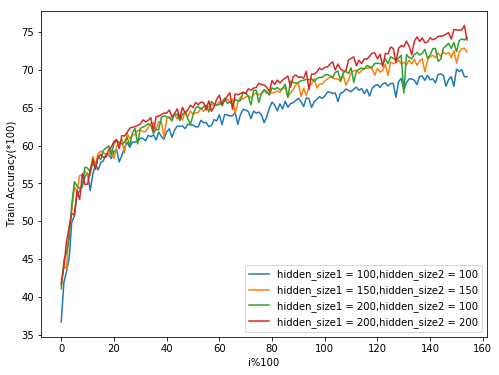

In [130]:
#training acc with hidden size differs
plt.figure(figsize=(8,6)) 
plt.plot(train_acc_i, label = "hidden_size1 = 100,hidden_size2 = 100")
plt.plot(train_acc_j, label = "hidden_size1 = 150,hidden_size2 = 150")
plt.plot(train_acc_f, label = "hidden_size1 = 200,hidden_size2 = 100")
plt.plot(train_acc_c, label = "hidden_size1 = 200,hidden_size2 = 200")
plt.xlabel("i%100")
plt.ylabel("Train Accuracy(*100)")
plt.legend(loc = 'best')

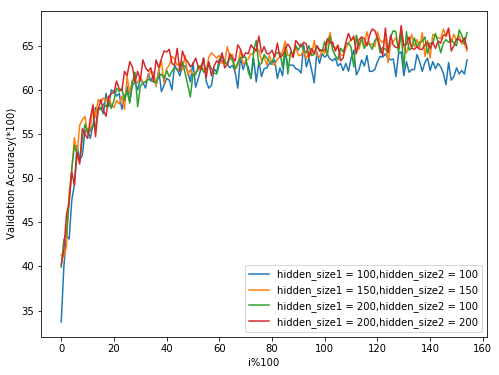

In [126]:
#val acc with hidden size differs
plt.figure(figsize=(8,6)) 
plt.plot(val_acc_i, label = "hidden_size1 = 100,hidden_size2 = 100")
plt.plot(val_acc_j, label = "hidden_size1 = 150,hidden_size2 = 150")
plt.plot(val_acc_f, label = "hidden_size1 = 200,hidden_size2 = 100")
plt.plot(val_acc_c, label = "hidden_size1 = 200,hidden_size2 = 200")
plt.xlabel("i%100")
plt.ylabel("Validation Accuracy(*100)")
plt.legend(loc = 'best')

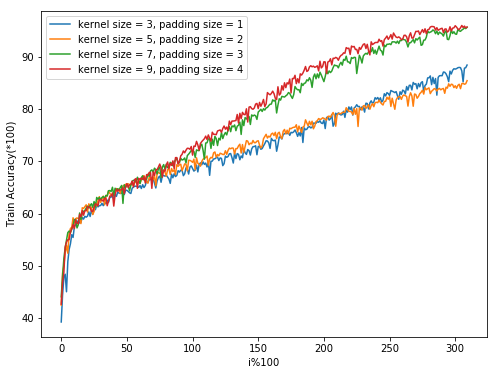

In [128]:
#training acc with kernel differs
plt.figure(figsize=(8,6)) 
plt.plot(train_acc_f1, label = "kernel size = 3, padding size = 1")
plt.plot(train_acc_a1, label = "kernel size = 5, padding size = 2")
plt.plot(train_acc_g, label = "kernel size = 7, padding size = 3")
plt.plot(train_acc_h, label = "kernel size = 9, padding size = 4")
plt.xlabel("i%100")
plt.ylabel("Train Accuracy(*100)")
plt.legend(loc = 'best')

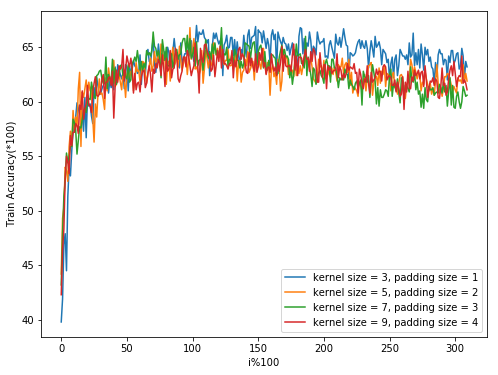

In [129]:
#val acc with hidden kernel differs
plt.figure(figsize=(8,6)) 
plt.plot(val_acc_f1, label = "kernel size = 3, padding size = 1")
plt.plot(val_acc_a1, label = "kernel size = 5, padding size = 2")
plt.plot(val_acc_g, label = "kernel size = 7, padding size = 3")
plt.plot(val_acc_h, label = "kernel size = 9, padding size = 4")
plt.xlabel("i%100")
plt.ylabel("Train Accuracy(*100)")
plt.legend(loc = 'best')